In [2]:
# from data_multi import Bandit_multi
# from learner_diag import NeuralUCBDiag
import numpy as np
import argparse
import pickle
import os
import time
import torch
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 


def truncated_gaussian(mean, variance, a, b, size):
    # Calculate the standard deviation from the variance
    std_dev = np.sqrt(variance)

    # Calculate the lower and upper bounds for truncation
    lower_bound = (a - mean) / std_dev
    upper_bound = (b - mean) / std_dev

    # Generate samples from the truncated normal distribution
    samples = truncnorm.rvs(lower_bound, upper_bound, loc=mean, scale=std_dev, size=size)

    return np.array(samples)

def reshape_context(context, A):
    d = context.shape[0]
    reshaped_context = np.zeros((A, d * A))
    
    for i in range(A):
        start_idx = i * d
        end_idx = start_idx + d
        reshaped_context[i, start_idx:end_idx] = context
    
    return reshaped_context

class Evaluation:

    def __init__(self, game_name, task, n_folds, horizon, game, label, context_type):
        self.game_name = game_name
        self.task = task
        self.n_folds = n_folds
        self.horizon = horizon
        self.game = game
        self.label =  label
        self.context_type = context_type
        

    def get_outcomes(self, game, ):
        outcomes = np.random.choice( game.n_outcomes , p= list( game.outcome_dist.values() ), size= self.horizon) 
        return outcomes

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def train_policy_once(self, alg, game, job):

        context_generator, jobid = job

        np.random.seed(jobid)

        alg.reset(context_generator.d)

        cumRegret =  np.zeros(self.horizon, dtype =float)

        history = [] 
        compteur = None
        for t in range(self.horizon):
            compteur = t
            if t % 1000 == 0 :
                print(t)

            context,distribution = context_generator.get_context()
            # outcome = 0 if distribution[0]>0.5 else 1  
            outcome = np.random.choice( 2 , p = distribution )

            # if alg.name == 'cbpsidejoint':
            #     context = reshape_context(context, alg.A)
            # else:
            #     context = np.expand_dims(context, axis=0)  #np.reshape(context, (-1,1))

            # print('context', context)
            action, data = alg.get_action(t, context)
            # print(data)
            gap = ( game.LossMatrix[0,...] - game.LossMatrix[1,...])  @ distribution 
            # estimates[action].append( (tdelta,gap) )
            data.append(gap)
            history.append( data )
            print('t', t, 'action', action, 'outcome', outcome, 'gaps', gap )

            feedback =  self.get_feedback( game, action, outcome )

            alg.update(action, feedback, outcome, t, context )

            i_star = np.argmin(  [ game.LossMatrix[i,...] @ np.array( distribution ) for i in range(alg.N) ]  )
            loss_diff = game.LossMatrix[action,...] - game.LossMatrix[i_star,...]
            val = loss_diff @ np.array( distribution )
            cumRegret[t] =  val

        return cumRegret, history
    

    def eval_policy_once(self, alg, game, job):

        context_generator, jobid = job

        np.random.seed(jobid+1)

        # alg.load(context_generator.d)

        cumRegret =  np.zeros(10000, dtype =float)

        history = [] 

        for t in range(10000):

            context,distribution = context_generator.get_context()
            outcome = np.random.choice( 2 , p = distribution )

            action, data = alg.get_action(t, context)

            gap = ( game.LossMatrix[0,...] - game.LossMatrix[1,...])  @ distribution 

            data.append(gap)
            data.append(context)
            history.append( data )
            print('t', t, 'action', action, 'outcome', outcome, 'gaps', gap )

            feedback =  self.get_feedback( game, action, outcome )

            i_star = np.argmin(  [ game.LossMatrix[i,...] @ np.array( distribution ) for i in range(alg.N) ]  )
            loss_diff = game.LossMatrix[action,...] - game.LossMatrix[i_star,...]
            val = loss_diff @ np.array( distribution )
            cumRegret[t] =  val

        return cumRegret, history
    
# class ToyContexts:

#     def __init__(self, ):
#         self.type = 'toy'
#         self.d = 2

#     def get_context(self, ):
#         p = np.random.uniform(0, 1)
#         return np.array([1,p]), [p, 1-p]


In [6]:

import cbpside
import rand_cbpside
import neural_lin_cbpside_disjoint
import rand_neural_lin_cbpside_disjoint

import games
import synthetic_data
import numpy as np
import random

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)


horizon = 1000
lbd_neural = 0
lbd_reg = 1
game = games.apple_tasting( )
task = 'quintic'

size = 5
w = np.array([1/size]*size)
if task == 'linear':
    context_generator = synthetic_data.LinearContexts( w,'imbalanced' )
elif task == 'quadratic':
    context_generator = synthetic_data.QuadraticContexts( w, 'imbalanced' )
elif task == 'sinusoid':
    context_generator = synthetic_data.NonLinearContexts( w,'imbalanced' )
elif task == 'bullseye':
    context_generator = synthetic_data.BullsEyeContexts(  )
elif task == 'mixture':
    context_generator = synthetic_data.MixtureContexts(  )
else:
    context_generator = synthetic_data.QuinticContexts(  )

# alg = cbpside.CBPside(game, 1.01, lbd_reg  )
# eval2 = Evaluation(None, None, None, horizon, game, None, None)
# job2 = context_generator, 0
# cumRegret_train, history_train = eval2.train_policy_once(alg, game, job2)
# cumRegret_eval, history_eval = eval2.eval_policy_once(alg, game, job2)

# sigma = 1
# K = 10
# epsilon = 10e-7
# alg = rand_cbpside.CBPside(game, 1.01, lbd_reg,  sigma, K , epsilon)
# eval2 = Evaluation(None, None, None, horizon, game, None, None)
# job2 = context_generator, 0
# cumRegret_train, history_train = eval2.train_policy_once(alg, game, job2)
# cumRegret_eval, history_eval = eval2.eval_policy_once(alg, game, job2)

# alg = neural_lin_cbpside_disjoint.CBPside( game,  1.01, lbd_neural, lbd_reg, 5,  'cuda:0'  )
# eval1 = Evaluation(None, None, None, horizon, game, None, None)
# job1 = context_generator, 0
# cumRegret, history = eval1.train_policy_once(alg, game, job1)

# sigma = 1
# K = 10
# epsilon = 10e-7
# alg = rand_neural_lin_cbpside_disjoint.CBPside( game,  1.01, lbd_neural, lbd_reg, sigma, K, epsilon, 15, 'cuda:0')
# eval1 = Evaluation(None, None, None, horizon, game, None, None)
# job1 = context_generator, 0
# cumRegret_train, history_train = eval1.train_policy_once(alg, game, job1)
cumRegret_eval, history_eval = eval1.eval_policy_once(alg, game, job1)


t 0 action 0 outcome 0 gaps 1
t 1 action 1 outcome 1 gaps -1
action 0 (1, 1)
factor 0.6868193972996417 width [[0.09488931]]
action 1 (1, 2)
factor 0.0 width [[0.33335324]]
pair [0, 1] tdelta [-1.21538982] confidence [[0.]]
t 2 action 0 outcome 1 gaps -1
action 0 (1, 1)
factor 0.0 width [[0.09117973]]
action 1 (1, 2)
factor 0.9235659834029679 width [[0.32361615]]
pair [0, 1] tdelta [-0.9797253] confidence [[0.29888087]]
t 3 action 0 outcome 1 gaps -1
action 0 (1, 1)
factor 0.0 width [[0.44415102]]
action 1 (1, 2)
factor 0.9561451915068133 width [[0.16897577]]
pair [0, 1] tdelta [1.07482612] confidence [[0.16156537]]
t 4 action 1 outcome 0 gaps 1
action 0 (1, 1)
factor 1.568012912004509 width [[1.23385123]]
action 1 (1, 2)
factor 0.9840064560022543 width [[0.14865224]]
pair [0, 1] tdelta [1.00720638] confidence [[0.14627477]]
t 5 action 1 outcome 0 gaps 1
action 0 (1, 1)
factor 1.6159054645218909 width [[0.09609009]]
action 1 (1, 2)
factor 0.0 width [[0.30732954]]
pair [0, 1] tdelta [-1.

In [8]:
import pickle

torch.save(alg.func, './quintic')

with open('./quintic_contexts', 'wb') as file:
    pickle.dump(alg.contexts, file)

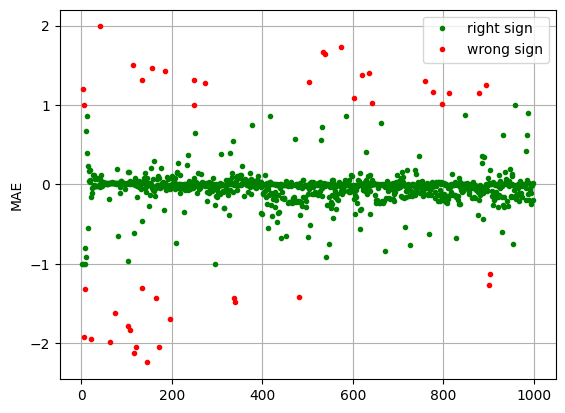

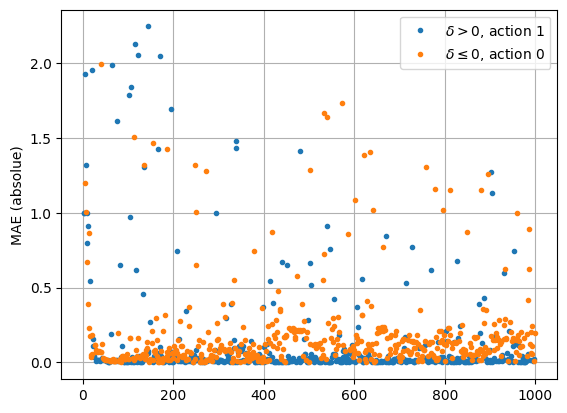

Text(0, 0.5, 'Regret')

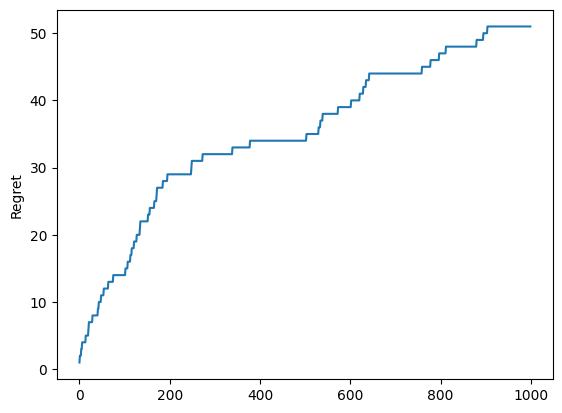

In [4]:
def MAE(y_true, y_pred):
    mae = y_true-y_pred
    return mae

right_sign = [ MAE(i[2], i[3]) if (i[3]>0 and i[2]>0) or (i[3]<=0 and i[2]<=0) else np.nan for i in history_train ]
wrong_sign = [ MAE(i[2], i[3]) if (i[3]>0 and i[2]<0) or (i[3]<=0 and i[2]>0) else np.nan for i in history_train ]
plt.plot( range( len(right_sign) ), right_sign , '.', label = 'right sign', color = 'green')
plt.plot( range(  len(wrong_sign ) ), wrong_sign , '.', label = 'wrong sign', color = 'red')
plt.ylabel('MAE')
plt.legend()
plt.grid()
# plt.savefig('./figures/CBPside_disjoint_{}_{}_errors.png'.format(task, lbd_neural) )
plt.show()

def MAE_abs(y_true, y_pred):
    mae = abs(y_true-y_pred)
    return mae

delta_pos = [ MAE_abs(i[2], i[3]) if i[3]>0 else np.nan for i in history_train ]
delta_neg = [ MAE_abs(i[2], i[3]) if i[3]<=0 else np.nan for i in history_train ]
plt.plot( range( len(delta_pos) ), delta_pos , '.', label = r'$\delta>0$, action 1')
plt.plot( range(  len(delta_neg ) ), delta_neg , '.', label = r'$\delta\leq 0$, action 0')
plt.ylabel('MAE (absolue)')
plt.legend()
plt.grid()
# plt.savefig('./figures/CBPside_disjoint_{}_{}_MAE.png'.format(task, lbd_neural) )
plt.show()

plt.plot( range(horizon) , np.cumsum(cumRegret_train) )
plt.ylabel('Regret')
# plt.savefig('./figures/CBPside_disjoint_{}_{}_regret.png'.format(task, lbd_neural) )

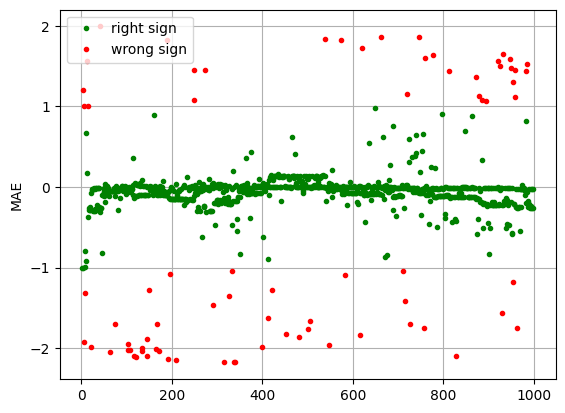

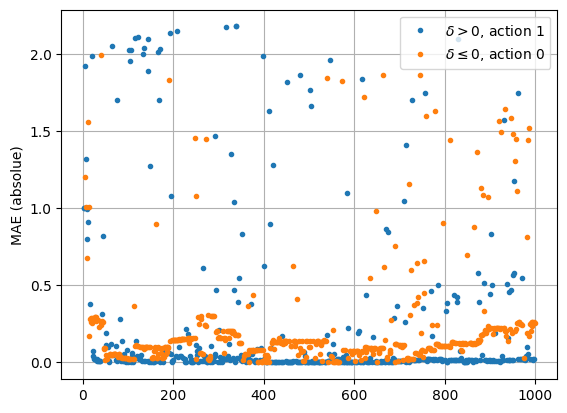

Text(0, 0.5, 'Regret')

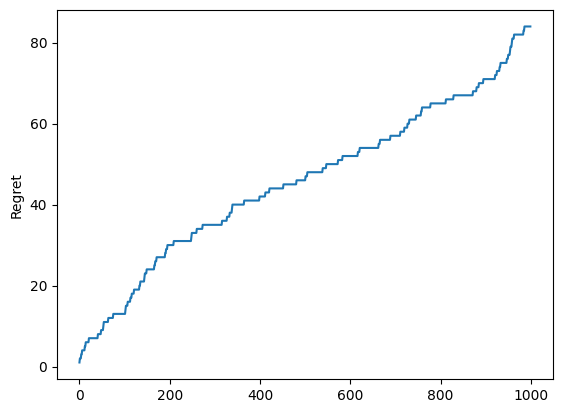

In [10]:
def MAE(y_true, y_pred):
    mae = y_true-y_pred
    return mae

right_sign = [ MAE(i[2], i[3]) if (i[3]>0 and i[2]>0) or (i[3]<=0 and i[2]<=0) else np.nan for i in history_train ]
wrong_sign = [ MAE(i[2], i[3]) if (i[3]>0 and i[2]<0) or (i[3]<=0 and i[2]>0) else np.nan for i in history_train ]
plt.plot( range( len(right_sign) ), right_sign , '.', label = 'right sign', color = 'green')
plt.plot( range(  len(wrong_sign ) ), wrong_sign , '.', label = 'wrong sign', color = 'red')
plt.ylabel('MAE')
plt.legend()
plt.grid()
# plt.savefig('./figures/CBPside_disjoint_{}_{}_errors.png'.format(task, lbd_neural) )
plt.show()

def MAE_abs(y_true, y_pred):
    mae = abs(y_true-y_pred)
    return mae

delta_pos = [ MAE_abs(i[2], i[3]) if i[3]>0 else np.nan for i in history_train ]
delta_neg = [ MAE_abs(i[2], i[3]) if i[3]<=0 else np.nan for i in history_train ]
plt.plot( range( len(delta_pos) ), delta_pos , '.', label = r'$\delta>0$, action 1')
plt.plot( range(  len(delta_neg ) ), delta_neg , '.', label = r'$\delta\leq 0$, action 0')
plt.ylabel('MAE (absolue)')
plt.legend()
plt.grid()
# plt.savefig('./figures/CBPside_disjoint_{}_{}_MAE.png'.format(task, lbd_neural) )
plt.show()

plt.plot( range(horizon) , np.cumsum(cumRegret_train) )
plt.ylabel('Regret')
# plt.savefig('./figures/CBPside_disjoint_{}_{}_regret.png'.format(task, lbd_neural) )

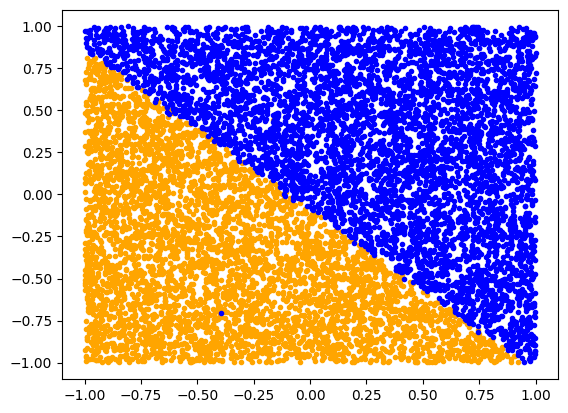

In [12]:
contexts = [ i[-1][0] for i in history_eval ]
contexts = np.array( [ [ i[0]+i[1], i[2]+i[3]+i[4] ] for i in contexts ] )

action0 = [ i[0] if i[0] == 0 else np.nan for i in history_eval ]
indices_action0 = np.where(~np.isnan(action0))[0]
contexts0 = contexts[indices_action0]
action1 = [ i[0] if i[0] == 1 else np.nan for i in history_eval ]
indices_action1 = np.where(~np.isnan(action1))[0]
contexts1 = contexts[indices_action1]

plt.plot(contexts0[:,0], contexts0[:,1], '.', color = 'orange')
plt.plot(contexts1[:,0], contexts1[:,1], '.', color = 'blue')

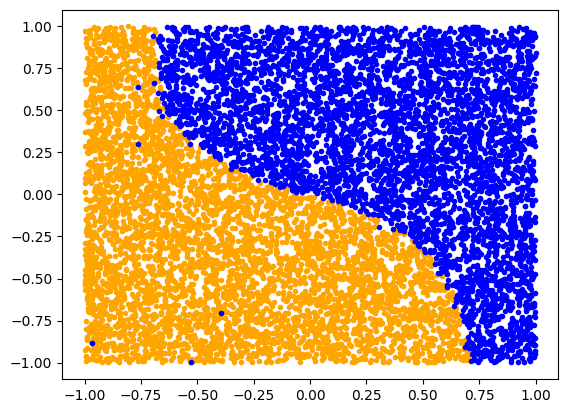

In [7]:
contexts = [ i[-1][0] for i in history_eval ]
contexts = np.array( [ [ i[0]+i[1], i[2]+i[3]+i[4] ] for i in contexts ] )

action0 = [ i[0] if i[0] == 0 else np.nan for i in history_eval ]
indices_action0 = np.where(~np.isnan(action0))[0]
contexts0 = contexts[indices_action0]
action1 = [ i[0] if i[0] == 1 else np.nan for i in history_eval ]
indices_action1 = np.where(~np.isnan(action1))[0]
contexts1 = contexts[indices_action1]

plt.plot(contexts0[:,0], contexts0[:,1], '.', color = 'orange')
plt.plot(contexts1[:,0], contexts1[:,1], '.', color = 'blue')

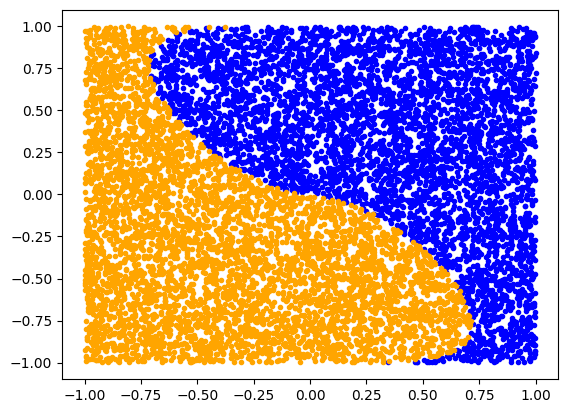

In [7]:
contexts = [ i[-1][0] for i in history_eval ]
contexts = np.array( [ [ i[0]+i[1], i[2]+i[3]+i[4] ] for i in contexts ] )

action0 = [ i[3] if i[3]>0 else np.nan for i in history_eval ]
indices_action0 = np.where(~np.isnan(action0))[0]
contexts0 = contexts[indices_action0]
action1 = [ i[3] if i[3]<=0 else np.nan for i in history_eval ]
indices_action1 = np.where(~np.isnan(action1))[0]
contexts1 = contexts[indices_action1]

plt.plot(contexts0[:,0], contexts0[:,1], '.', color = 'blue')
plt.plot(contexts1[:,0], contexts1[:,1], '.', color = 'orange')

In [2]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

def step(func, loader, opt):
    #""Standard training/evaluation epoch over the dataset"""
    symbols = [ np.unique(alg.game.FeedbackMatrix[i,...]) for i in range(alg.N) ]
    for X, y, feedbacks, actions in loader:
        X, y  = X.to(alg.device).float(), y.to(alg.device).float()
        fdks = torch.nn.functional.one_hot(feedbacks[:,0]).to(alg.device).float()
        # print(X.shape, y.shape, fdks.shape)
        loss = 0
        losses = []
        for i in range(alg.N): 
            mask = (actions == i)[:,0]
            X_filtered = X[mask]
            fdks_filtered = fdks[mask]
            for s in symbols[i]:
                y_filtered = fdks_filtered[:,s].unsqueeze(1)
                weights = torch.from_numpy( alg.weights[i] ).unsqueeze(0).float().to(alg.device)
                # print(X_filtered.shape, y_filtered.shape, fdks_filtered.shape)
                # print(func(X_filtered)[:10])
                pred = func(X_filtered) @ weights.T
                # print(pred.T)
                # print('pred',pred.shape,'y_filtered', y_filtered.shape)
                # loss+= nn.MSELoss()(pred, y_filtered)
                val = nn.MSELoss()(pred, y_filtered)
                loss += val
                losses.append(val.item())
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), losses

alg.weights = np.vstack( [ alg.contexts[i]['weights'] for i in range(alg.N) ] )
func = copy.deepcopy(alg.func0)
optimizer = optim.Adam(func.parameters(), lr=1e-3, weight_decay = 0 )
dataloader = DataLoader(alg.hist, batch_size=len(alg.hist), shuffle=True) 
loss_monitor = []

for _ in range(1000):
    train_loss, losses = step(func, dataloader, optimizer)
    print(_, train_loss, losses)
    print(loss_monitor)
    loss_monitor.append(train_loss)
    if len(loss_monitor) >= 2:
        loss_monitor = loss_monitor[-2:]

    # if _ % 100 == 0:
    #     print(train_loss)

    
    if len(loss_monitor) >= 2 and abs(loss_monitor[1] - loss_monitor[0]) < 1e-4:
        diff = abs(loss_monitor[1] - loss_monitor[0])
        print('diff', diff)
        break


NameError: name 'alg' is not defined

In [26]:
for name, param in alg.func0.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc1.weight tensor([[ 0.0594,  0.1542,  0.0507, -0.0591, -0.0569],
        [ 0.0920,  0.1111,  0.1290, -0.1496, -0.0400],
        [ 0.1039,  0.0358, -0.0003, -0.0534,  0.1169],
        [ 0.0395,  0.1941, -0.0957,  0.0034,  0.0710],
        [-0.1535, -0.0413,  0.0966,  0.1625, -0.0366]], device='cuda:0')
fc1.bias tensor([0., 0., 0., 0., 0.], device='cuda:0')
fc2.weight tensor([[-0.1696, -0.0228,  0.0280,  0.0073,  0.1113],
        [ 0.0282,  0.0434, -0.0802, -0.0865,  0.0608],
        [-0.0730, -0.0883, -0.0419, -0.0805,  0.0566],
        [ 0.0610,  0.0467, -0.0755,  0.0244, -0.0077],
        [ 0.0116, -0.0594, -0.1244, -0.0102, -0.1034]], device='cuda:0')
fc2.bias tensor([0., 0., 0., 0., 0.], device='cuda:0')


In [ ]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

optimizer = optim.Adam(alg.func.parameters(), lr=1e-3, weight_decay = alg.lbd_neural )
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99)
lrs = []
for _ in range(1000):
    current_lr = optimizer.param_groups[0]['lr']
    lrs.append(current_lr)
    optimizer.step()
    scheduler.step()
    
plt.plot(lrs)

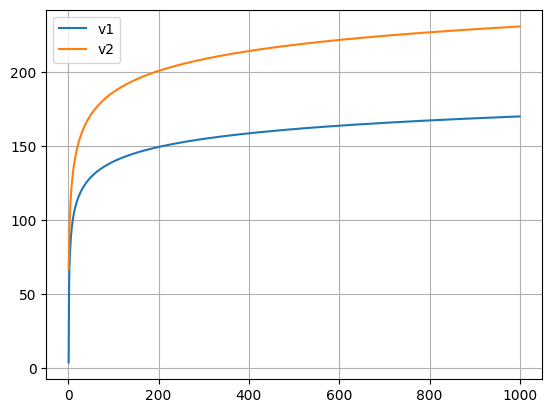

In [16]:
v1 = []
v2 = []
sigma_i = 2
d = 1000
lbd_reg = 1
N = 2
for t in range(1,1000):
    v1.append(  sigma_i * (  np.sqrt(  d * np.log(t) + 2 * np.log(1/t**2)   ) + np.sqrt(lbd_reg) * sigma_i )  )
    v2.append( sigma_i * (  np.sqrt( 2 * ( d  * np.log( 1 + t * np.log(N * 1)/lbd_reg ) +  np.log(1/t**2) ) ) + np.sqrt(lbd_reg)  ) )

plt.plot(range(1,1000),v1, label = 'v1')
plt.plot(range(1,1000),v2, label = 'v2')
plt.legend()
plt.grid()

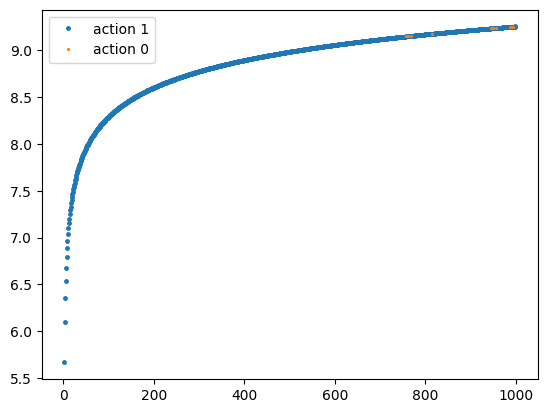

In [5]:
action0 = [ np.nan if history[i][0] == 1 else history[i][1] for i in range(len(history))]
# action0 = [ i if type(i) == float or type(i) == int else i[0] for i in action0 ]
action0 = [ i[0] if type(i) == np.ndarray else i for i in action0 ]
action1 = [ np.nan if history[i][0] == 0 else history[i][1] for i in range(len(history))]
action1 = [ i[0] if type(i) == np.ndarray else i for i in action1 ]


plt.plot( range(horizon) , action1 ,'.', label = 'action 1', markersize=5)
plt.plot( range(horizon) , action0, '.', label = 'action 0', markersize=2.5)
plt.legend()

In [1]:
import numpy as np
import scipy as sp
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import copy

from scipy.optimize import minimize

# import itertools

class Network(nn.Module):
    def __init__(self, output_dim, dim, hidden_size=10):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(dim, hidden_size)
        self.activate = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_dim)
    def forward(self, x):
        x = self.fc2(self.activate(self.fc1(x)))
        return x
    
model = Network( 1 , 15, 5 )
model

Network(
  (fc1): Linear(in_features=15, out_features=5, bias=True)
  (activate): ReLU()
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
import synthetic_data
import numpy as np
from scipy.special import expit, logit

class LinearContexts:
    def __init__(self,  d, task):
        self.d = d
        self.w = np.ones(self.d) * 1/(2*self.d)
        self.b = 1/2
        self.type = 'linear'
        self.task = task
    
    def get_context(self, ):

        if self.task == 'imbalanced':
            p = np.random.uniform(0, 0.2) if np.random.uniform(0, 1)<0.5 else np.random.uniform(0.8, 1)
            mean = np.array([-0.00069175, -0.00069175, -0.00069175, -0.00069175, -0.00069175])
            std = np.array([4.04096508, 4.04096508, 4.04096508, 4.04096508, 4.04096508])
        elif self.task == 'balanced':
            p = np.random.uniform(0.4, 0.6) 
            mean = np.array([-0.00060318, -0.00060318, -0.00060318, -0.00060318, -0.00060318])
            std = np.array([0.57770456, 0.57770456, 0.57770456, 0.57770456, 0.57770456])

        context = (p-self.b) * 1/self.w
        val = [ p, 1-p ]

        context = np.array(context)
        context = ( context - mean ) / std

        return context , val 
    
T = 1000000
size = 5
w = np.array([1/size]*size)
context_generator = LinearContexts( size,'imbalanced' )
contexts = np.empty((T, size))
dists = []
for _ in range(T):
    context,distribution = context_generator.get_context()
    contexts[_] = context
    dists.append(distribution[0])

print( np.mean(contexts , 0) )
print( np.std(contexts , 0) )
print(np.min(contexts,0))
print(np.max(contexts,0))
# plt.hist(dists, 30)

[0.00065564 0.00065564 0.00065564 0.00065564 0.00065564]
[0.99997916 0.99997916 0.99997916 0.99997916 0.99997916]
[-1.23715681 -1.23715681 -1.23715681 -1.23715681 -1.23715681]
[1.2374982 1.2374982 1.2374982 1.2374982 1.2374982]


In [19]:
import synthetic_data
size = 5
w = np.array([1/size]*size)
# context_generator = synthetic_data.LinearContexts( w,'imbalanced' )
# context_generator = synthetic_data.QuadraticContexts( w,'imbalanced' )
# context_generator = synthetic_data.NonLinearContexts( w,'imbalanced' )
# context_generator = synthetic_data.QuinticContexts(  )
context_generator = synthetic_data.BullsEyeContexts(  )
# context_generator = synthetic_data.MixtureContexts(  )

X_train, y_train = None, None
X_test, y_test = None, None

for _ in range(10000):

    context,distribution = context_generator.get_context()
    outcome = np.random.choice( 2 , p = distribution ) 


    X_train = context if X_train is None else np.concatenate((X_train, context), axis=0)
    y_train = [[outcome]] if y_train is None else np.concatenate( (y_train, [[outcome]]), axis=0)


for _ in range(10000):

    context,distribution = context_generator.get_context()
    outcome = np.random.choice( 2 , p = distribution ) 
    X_test = context if X_test is None else np.concatenate((X_test, context), axis=0)
    y_test = [[outcome]] if y_test is None else np.concatenate( (y_test, [[outcome]]), axis=0)

print( X_train.shape , y_train.shape )
print( X_test.shape , y_test.shape )

(10000, 5) (10000, 1)
(10000, 5) (10000, 1)


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

class Network(nn.Module):
    def __init__(self,  d, m):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(d, m)
        self.activate1 = nn.Tanh() #nn.ReLU()
        self.fc2 = nn.Linear(m, m)
        self.activate2 = nn.Tanh() #nn.ReLU()
        self.fc3 = nn.Linear(m, 1)
        nn.init.normal_(self.fc1.weight, mean=0, std=0.1)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.1)
        nn.init.normal_(self.fc3.weight, mean=0, std=0.1)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)
    def forward(self, x):
        x = self.fc3( self.activate2( self.fc2( self.activate1( self.fc1(x) ) ) ) )
        # x = self.fc3( self.activate2( self.fc2( self.activate1( self.fc1(x) ) ) ) )
        # x = self.fc2( self.activate1( self.fc1(x) ) ) 
        return x

# Set the random seed for reproducibility
torch.manual_seed(42)

# Create the model instance
model = Network(5, 15).to('cuda')

# Define the loss function (mean squared error) and optimizer
# optimizer = optim.SGD(model.parameters(), lr=0.01)
optimizer = optim.Adam(model.parameters(), lr=1e-1, weight_decay = 0 )
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99)

for _ in range(1000):

    outputs = model( torch.tensor(X_train).to('cuda').float() ) 
    loss = nn.MSELoss()(outputs, torch.tensor(y_train).to('cuda').float() )
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f'Epoch {_}, Loss: {loss.item():.4f}')

# for name, param in alg.func.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)
# # Test the model

predicted_output = model( torch.tensor(X_test).to('cuda').float() ) 

Epoch 0, Loss: 0.8449
Epoch 1, Loss: 0.6379
Epoch 2, Loss: 0.1784
Epoch 3, Loss: 1.0397
Epoch 4, Loss: 0.2581
Epoch 5, Loss: 0.1920
Epoch 6, Loss: 0.2144
Epoch 7, Loss: 0.2350
Epoch 8, Loss: 0.2047
Epoch 9, Loss: 0.1852
Epoch 10, Loss: 0.2260
Epoch 11, Loss: 0.2452
Epoch 12, Loss: 0.1844
Epoch 13, Loss: 0.1773
Epoch 14, Loss: 0.1955
Epoch 15, Loss: 0.1809
Epoch 16, Loss: 0.1661
Epoch 17, Loss: 0.1532
Epoch 18, Loss: 0.1531
Epoch 19, Loss: 0.1630
Epoch 20, Loss: 0.1593
Epoch 21, Loss: 0.1453
Epoch 22, Loss: 0.1430
Epoch 23, Loss: 0.1501
Epoch 24, Loss: 0.1487
Epoch 25, Loss: 0.1413
Epoch 26, Loss: 0.1412
Epoch 27, Loss: 0.1447
Epoch 28, Loss: 0.1406
Epoch 29, Loss: 0.1332
Epoch 30, Loss: 0.1338
Epoch 31, Loss: 0.1388
Epoch 32, Loss: 0.1372
Epoch 33, Loss: 0.1322
Epoch 34, Loss: 0.1328
Epoch 35, Loss: 0.1363
Epoch 36, Loss: 0.1348
Epoch 37, Loss: 0.1309
Epoch 38, Loss: 0.1309
Epoch 39, Loss: 0.1331
Epoch 40, Loss: 0.1329
Epoch 41, Loss: 0.1312
Epoch 42, Loss: 0.1309
Epoch 43, Loss: 0.131

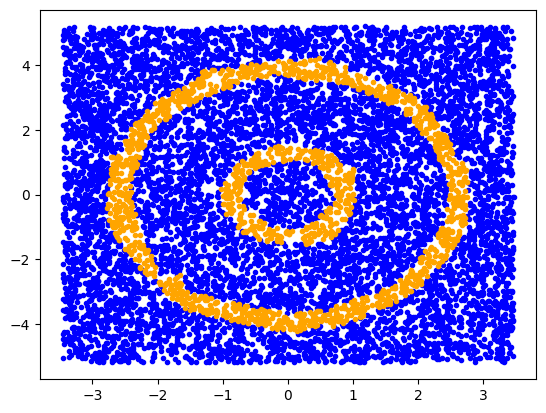

In [21]:
contexts = np.array( [ [ i[0]+i[1], i[2]+i[3]+i[4] ] for i in X_test ] )

action0 = [ i[0] if i>0.5 else np.nan for i in predicted_output.detach().cpu().numpy() ]
indices_action0 = np.where(~np.isnan(action0))[0]
contexts0 = contexts[indices_action0]

action1 = [ i[0] if i<=0.5 else np.nan for i in predicted_output.detach().cpu().numpy() ]
indices_action1 = np.where(~np.isnan(action1))[0]
contexts1 = contexts[indices_action1]

plt.plot(contexts0[:,0], contexts0[:,1], '.', color = 'blue')
plt.plot(contexts1[:,0], contexts1[:,1], '.', color = 'orange')

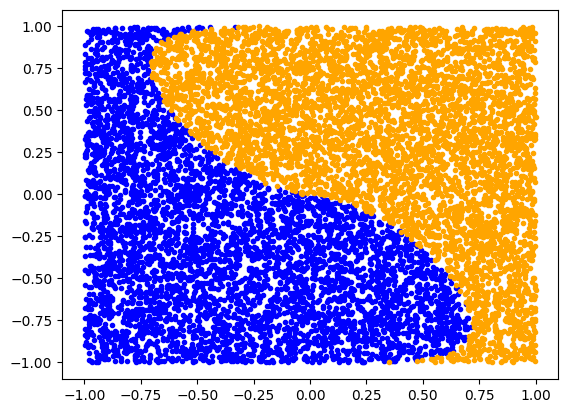

In [100]:
contexts = np.array( [ [ i[0]+i[1], i[2]+i[3]+i[4] ] for i in X_test ] )

action0 = [ i[0] if i>0.5 else np.nan for i in y_test ]
indices_action0 = np.where(~np.isnan(action0))[0]
contexts0 = contexts[indices_action0]

action1 = [ i[0] if i<=0.5 else np.nan for i in y_test ]
indices_action1 = np.where(~np.isnan(action1))[0]
contexts1 = contexts[indices_action1]

plt.plot(contexts0[:,0], contexts0[:,1], '.', color = 'blue')
plt.plot(contexts1[:,0], contexts1[:,1], '.', color = 'orange')

In [37]:

import torch
import torch.nn as nn
import torch.optim as optim

# class Network(nn.Module):
#     def __init__(self, output_dim, dim, hidden_size=10):
#         super(Network, self).__init__()
#         self.fc1 = nn.Linear(dim, hidden_size)
#         self.activate = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size, output_dim)
#     def forward(self, x):
#         return self.fc2(self.activate(self.fc1(x)))

class Network(nn.Module):
    def __init__(self, output_dim, dim, hidden_size=10):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(dim, hidden_size)
        self.activate = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_dim)
        self.sigmoid = nn.Sigmoid( )
    def forward(self, x):
        x = self.fc2(self.activate(self.fc1(x)))
        x = self.sigmoid(x)
        return x

# Create an instance of your model
model = Network(1, 15).cuda()

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1) #, weight_decay=1

length = labels.shape[0]
index = np.arange(length)
np.random.shuffle(index)

epochs = 1000
for epoch in range(epochs):
    running_loss = 0.0
    for i in index:
        input, label = torch.tensor(features[i], dtype=torch.float).cuda() ,  torch.tensor(labels[i], dtype=torch.float).cuda() 
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(input)
        # print(output)
        # loss = nn.MSELoss()(output, label)
        loss = nn.BCELoss()(output, label)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track the loss
        running_loss += loss.item()

    # Print the average loss for the epoch
    print(f"Epoch {epoch + 1} Loss: {running_loss }")

print("Training finished.")

Epoch 1 Loss: 191.61819949746132
Epoch 2 Loss: 171.81261309236288
Epoch 3 Loss: 160.70064198412
Epoch 4 Loss: 151.76865445636213
Epoch 5 Loss: 144.26779567822814
Epoch 6 Loss: 139.35872966982424
Epoch 7 Loss: 135.98660619184375
Epoch 8 Loss: 133.81815046432894
Epoch 9 Loss: 133.40905308397487
Epoch 10 Loss: 129.53546123723208
Epoch 11 Loss: 128.15112248023797
Epoch 12 Loss: 127.52097333655547
Epoch 13 Loss: 127.6262948125077
Epoch 14 Loss: 124.9297045631356
Epoch 15 Loss: 124.34213168322094
Epoch 16 Loss: 125.65422660583954
Epoch 17 Loss: 125.57103053475021
Epoch 18 Loss: 125.53729559366275
Epoch 19 Loss: 124.15089444805108
Epoch 20 Loss: 123.72886606978
Epoch 21 Loss: 123.4920854429688
Epoch 22 Loss: 123.12331012448703
Epoch 23 Loss: 123.13061843031414
Epoch 24 Loss: 123.01522998188307
Epoch 25 Loss: 122.70486598303205
Epoch 26 Loss: 121.8172483319272
Epoch 27 Loss: 121.42813189881213
Epoch 28 Loss: 121.73620852425609
Epoch 29 Loss: 121.6918568751455
Epoch 30 Loss: 121.07351516577205


In [32]:
import numpy as np

class LinearContexts:
    def __init__(self,  w, task):
        self.d = len(w) # number of features
        self.w = w
        self.type = 'linear'
        self.task = task
    
    def get_context(self, ):

        if self.task == 'imbalanced':
            context = truncated_gaussian(0, 0.1, 0, 1, self.d) if np.random.uniform(0,1)<0.5 else truncated_gaussian(1, 0.1, 0, 1, self.d)
        else:
            context = truncated_gaussian(0.5, 1, 0, 1, self.d)
        # cont = context.reshape(self.d,1)
        p = self.w @ context
        val = [ p, 1-p ]
        context = context - np.ones(5) * 0.5
        context = context.astype(np.float64)
        return context , val 

A = 3
size = 5
w = np.array([1/size]*size)
context_generator = LinearContexts(w, 'imbalanced')

for _ in range(100):
    c,d = context_generator.get_context()
    print(d)
    c = reshape_context(c, A)

    e_y = np.zeros( A )
    outcome = 0 if d[0]<0.5 else 1
    action = np.random.randint(2)
    if action == 0:
        e_y[-1] = 1
    else:
        e_y[outcome] = 1
    print(e_y)
    Y_t = e_y.reshape(A,1)
    features = c if features is None else np.concatenate((features, c), axis=0)
    labels = Y_t if labels is None else np.concatenate((labels, Y_t), axis=0)


[0.781837598653284, 0.21816240134671605]
[0. 1. 0.]
[0.6556621380150109, 0.34433786198498906]
[0. 0. 1.]
[0.7789886507633803, 0.2210113492366197]
[0. 1. 0.]
[0.6950717806433822, 0.30492821935661785]
[0. 0. 1.]
[0.2905294738750467, 0.7094705261249533]
[0. 0. 1.]
[0.7637702218739297, 0.23622977812607027]
[0. 0. 1.]
[0.2930578692126846, 0.7069421307873154]
[0. 0. 1.]
[0.8009125498861533, 0.19908745011384665]
[0. 0. 1.]
[0.7022237121316804, 0.29777628786831956]
[0. 0. 1.]
[0.838445309974184, 0.16155469002581602]
[0. 1. 0.]
[0.8483303844579365, 0.15166961554206349]
[0. 1. 0.]
[0.37632054322920316, 0.6236794567707968]
[1. 0. 0.]
[0.81904645005698, 0.18095354994302004]
[0. 1. 0.]
[0.11547315940506402, 0.884526840594936]
[0. 0. 1.]
[0.20238851634306218, 0.7976114836569378]
[1. 0. 0.]
[0.16724887449258274, 0.8327511255074173]
[1. 0. 0.]
[0.276104891987722, 0.723895108012278]
[1. 0. 0.]
[0.6470652508863118, 0.35293474911368816]
[0. 1. 0.]
[0.7852475857655943, 0.21475241423440572]
[0. 0. 1.]
[0.7

In [33]:
d = 10
sigma_i = 2
lbd = 0.05
value1, value2, value3, value4 = [], [], [], []
for t in range(1, 10000):
    value1.append(  d * (  np.sqrt(  d * np.log(t) + 2 * np.log(1/t**2)   ) + 2 ) )
    value2.append(  d * (  np.sqrt(  (d+1) * np.log(t)   ) + 2 ) )
    value3.append(  sigma_i * (  np.sqrt(  d * np.log(t) + 2 * np.log(1/t**2)   ) +  sigma_i ) )
    value4.append(  sigma_i * (  np.sqrt(  d * np.log(t) + 2 * np.log(1/t**2)   ) + np.sqrt(lbd) * sigma_i ) )

plt.plot( range(9999), value1, label = 'width1')
plt.plot( range(9999), value2, label = 'width2')
plt.plot( range(9999), value3, label = 'width3')
plt.plot( range(9999), value4, label = 'width4')
plt.legend()

p = 435
sigma_i = 2
lbd = 0.05
value3, value4 = [], []
for t in range(1, 10000):
    value3.append(  sigma_i * (  np.sqrt(  p * np.log(t) + 2 * np.log(1/t**2)   ) +  sigma_i ) )
    value4.append(  sigma_i * (  np.sqrt(  p * np.log(t) + 2 * np.log(1/t**2)   ) + np.sqrt(lbd) * sigma_i ) )

plt.plot( range(9999), value3, label = 'width3')
plt.plot( range(9999), value4, label = 'width4')
plt.legend()

size = 10
w = np.array([1/size]*size)
context_generator = synthetic_data.LinearContexts( w,'balanced' )

dis = []
for _ in range(1000):
    c,d = context_generator.get_context()
    dis.append(d[0])

plt.hist(dis, bins=30, density=True, alpha=0.7)